In [ ]:
from google.colab import files
import zipfile
import os

uploaded = files.upload()

Saving defungi.zip to defungi.zip


In [ ]:
filename = list(uploaded.keys())[0]
with zipfile.ZipFile(filename,'r') as ref:
    ref.extractall('/content/defungi')

data_dir = '/content/defungi'
class_names = ['H1', 'H2', 'H3', 'H5', 'H6']

In [ ]:
from PIL import Image
import pandas as pd
import numpy as np

data = '/content/defungi'
class_names = ['H1', 'H2', 'H3', 'H5', 'H6']
meta_data = []

for cls in class_names:
    cls_path = os.path.join(data_dir, cls)
    img_files = os.listdir(cls_path)
    widths, heights, modes = [], [], []

    for img_file in img_files[:50]:
        try:
            img = Image.open(os.path.join(cls_path, img_file))
            widths.append(img.width)
            heights.append(img.height)
            modes.append(img.mode)
        except:
            continue

    avg_width = np.mean(widths)
    avg_height = np.mean(heights)
    mode = max(set(modes), key=modes.count)

    meta_data.append({
        'Class': cls,
        'Image Count': len(img_files),
        'Avg Width': round(avg_width, 2),
        'Avg Height': round(avg_height, 2),
        'Most Common Mode': mode
    })

df_meta = pd.DataFrame(meta_data)
print(df_meta)


  Class  Image Count  Avg Width  Avg Height Most Common Mode
0    H1         4404      500.0       500.0              RGB
1    H2         2334      500.0       500.0              RGB
2    H3          819      500.0       500.0              RGB
3    H5          818      500.0       500.0              RGB
4    H6          739      500.0       500.0              RGB


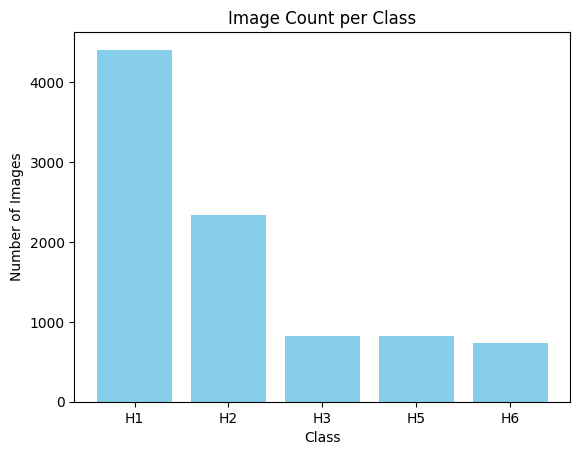

In [ ]:
import matplotlib.pyplot as plt

class_counts = {}
for cls in class_names:
    cls_path = os.path.join(data_dir, cls)
    class_counts[cls] = len(os.listdir(cls_path))

plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title('Image Count per Class')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()


In [ ]:
img_shapes = []
for cls in class_names:
    folder = os.path.join(data_dir, cls)
    for img_file in os.listdir(folder)[:50]:
        try:
            img = Image.open(os.path.join(folder, img_file))
            img_shapes.append(img.size)
        except:
            continue

widths, heights = zip(*img_shapes)
print(f"Average width: {np.mean(widths):.2f}, Average height: {np.mean(heights):.2f}")
print(f"Most common image size: {max(set(img_shapes), key = img_shapes.count)}")


Average width: 500.00, Average height: 500.00
Most common image size: (500, 500)


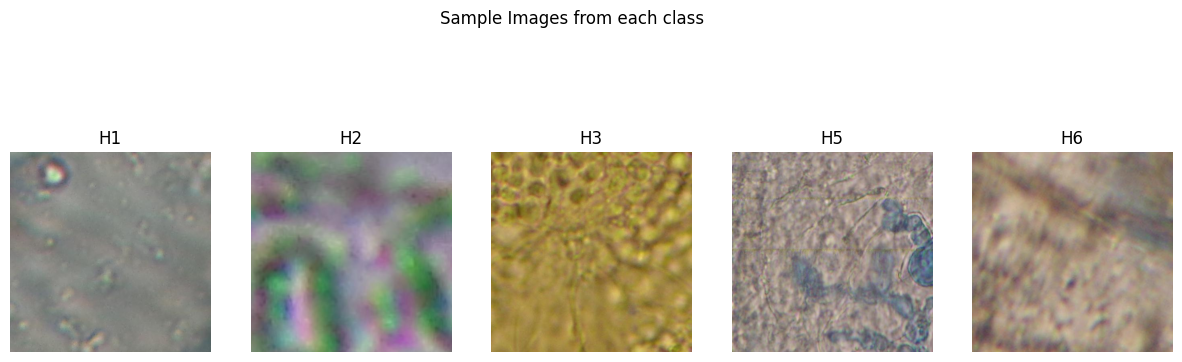

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(15, 5))
for i, cls in enumerate(class_names):
    sample_path = os.path.join(data, cls, os.listdir(os.path.join(data, cls))[0])
    img = Image.open(sample_path)
    axs[i].imshow(img, cmap='gray')
    axs[i].set_title(cls)
    axs[i].axis('off')
plt.suptitle("Sample Images from each class")
plt.show()


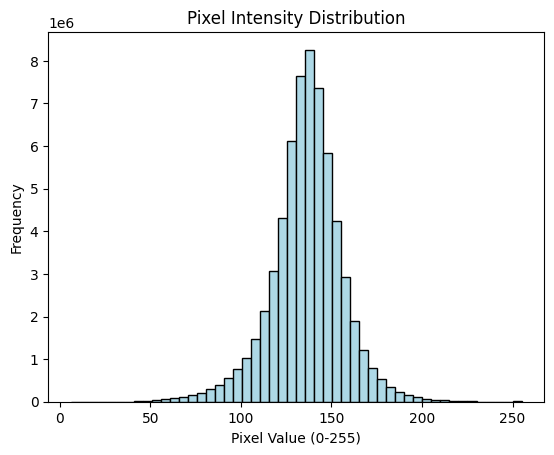

In [ ]:
import cv2

gray_levels = []
for cls in class_names:
    folder = os.path.join(data_dir, cls)
    for img_file in os.listdir(folder)[:50]:
        img_path = os.path.join(folder, img_file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            gray_levels.extend(img.flatten())

plt.hist(gray_levels, bins=50, color='lightblue', edgecolor='black')
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel Value (0-255)")
plt.ylabel("Frequency")
plt.show()


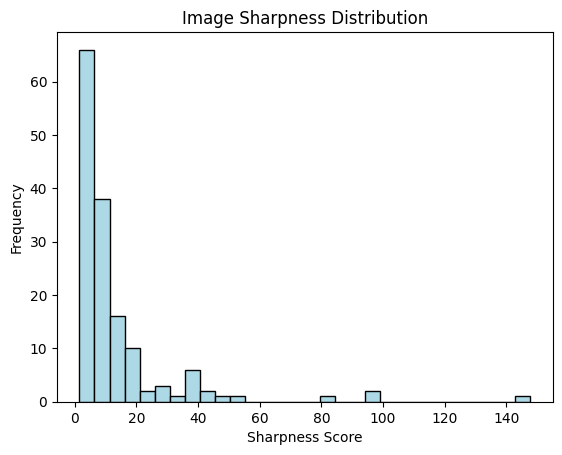

In [ ]:
import cv2

def variance_of_laplacian(image):
    return cv2.Laplacian(image, cv2.CV_64F).var()

sharpness_scores = []
for cls in class_names:
    for img_file in os.listdir(os.path.join(data_dir, cls))[:30]:
        img = cv2.imread(os.path.join(data_dir, cls, img_file), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            score = variance_of_laplacian(img)
            sharpness_scores.append(score)

plt.hist(sharpness_scores, bins=30, color='lightblue', edgecolor='black')
plt.title("Image Sharpness Distribution")
plt.xlabel("Sharpness Score")
plt.ylabel("Frequency")
plt.show()


In [ ]:
import hashlib

def hash_img(img_path):
    with open(img_path, 'rb') as f:
        return hashlib.md5(f.read()).hexdigest()

all_hashes = set()
duplicates = []
for cls in class_names:
    for img_file in os.listdir(os.path.join(data_dir, cls)):
        img_path = os.path.join(data_dir, cls, img_file)
        h = hash_img(img_path)
        if h in all_hashes:
            duplicates.append(img_file)
        all_hashes.add(h)

print(f"Number of duplicate images: {len(duplicates)}")



Number of duplicate images: 59


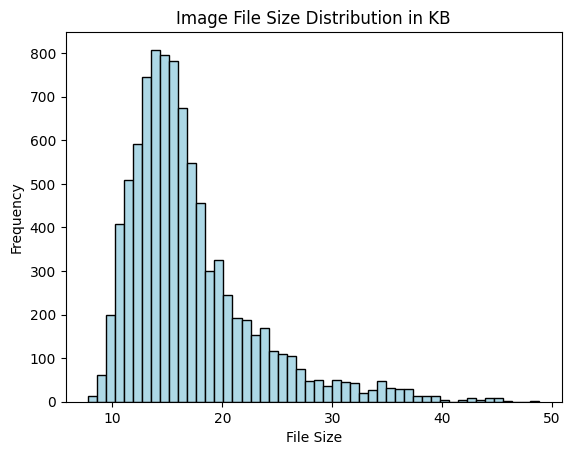

In [ ]:
file_sizes = []
for cls in class_names:
    for img_file in os.listdir(os.path.join(data_dir, cls)):
        file_path = os.path.join(data_dir, cls, img_file)
        file_sizes.append(os.path.getsize(file_path) / 1024)

plt.hist(file_sizes, bins=50, color='lightblue', edgecolor='black')
plt.title("Image File Size Distribution in KB")
plt.xlabel("File Size")
plt.ylabel("Frequency")
plt.show()


In [ ]:
import os
import random
import shutil
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive

drive.mount('/content/drive')
data_dir = '/content/defungi'
balanced_dir = '/content/balanced_rgb_2500_defungi'
drive_save_path = '/content/drive/MyDrive/balanced_rgb_2500_defungi'

class_names = ['H1', 'H2', 'H3', 'H5', 'H6']
target_count = 2500

Mounted at /content/drive


In [ ]:
#Augmentation technique
augmentor = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    fill_mode='nearest'
)

In [ ]:
#Function for Augmentation
def augment_images(input_folder, output_folder, target_total):
    os.makedirs(output_folder, exist_ok=True)
    original_files = os.listdir(input_folder)

    for f in original_files:
        shutil.copy(os.path.join(input_folder, f), os.path.join(output_folder, f))

    i = 0
    while len(os.listdir(output_folder)) < target_total:
        img_file = random.choice(original_files)
        img_path = os.path.join(input_folder, img_file)
        try:
            img = Image.open(img_path).resize((224, 224)).convert('RGB')
            x = augmentor.random_transform(np.array(img))
            new_name = f"aug_{i}_{img_file}"
            Image.fromarray(x.astype('uint8')).save(os.path.join(output_folder, new_name))
            i += 1
        except Exception as e:
            print(f"Skipping {img_file}: {e}")

In [ ]:
#Function for undersampling
def undersample_images(input_folder, output_folder, keep_n):
    os.makedirs(output_folder, exist_ok=True)
    all_images = os.listdir(input_folder)
    selected = random.sample(all_images, keep_n)
    for f in selected:
        shutil.copy(os.path.join(input_folder, f), os.path.join(output_folder, f))

In [ ]:
for cls in class_names:
    print(f"Processing class: {cls}")
    input_path = os.path.join(data_dir, cls)
    output_path = os.path.join(balanced_dir, cls)
    img_count = len(os.listdir(input_path))

    if img_count > target_count:
        undersample_images(input_path, output_path, target_count)
    elif img_count < target_count:
        augment_images(input_path, output_path, target_count)
    else:
        shutil.copytree(input_path, output_path)


Processing class: H1
Processing class: H2
Processing class: H3
Processing class: H5
Processing class: H6


In [ ]:
shutil.move(balanced_dir, drive_save_path)

'/content/drive/MyDrive/balanced_rgb_2500_defungi'

In [ ]:
from google.colab import files
import zipfile
import os

uploaded = files.upload()

Saving balanced_defungi.zip to balanced_defungi.zip


In [ ]:
filename = list(uploaded.keys())[0]
with zipfile.ZipFile(filename,'r') as ref:
    ref.extractall('/content/balanced_defungi')

balanced_data_dir = '/content/balanced_defungi'
class_names = ['H1', 'H2', 'H3', 'H5', 'H6']

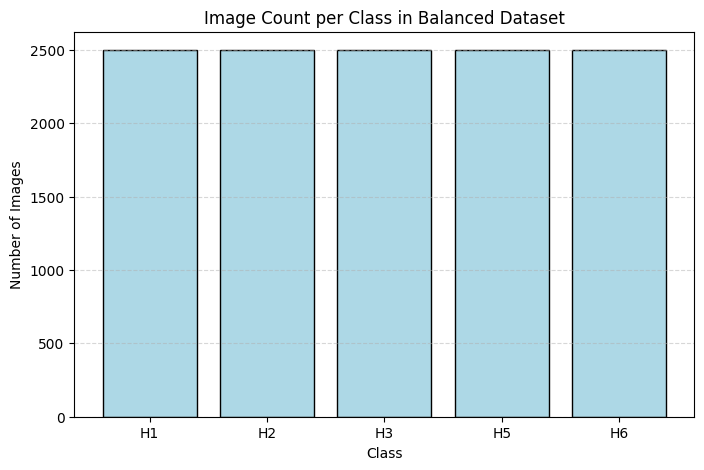

In [ ]:
import matplotlib.pyplot as plt

class_counts = {}
for cls in class_names:
    folder_path = os.path.join(balanced_data_dir, cls)
    image_count = len(os.listdir(folder_path))
    class_counts[cls] = image_count

plt.figure(figsize=(8, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='lightblue', edgecolor='black')
plt.title('Image Count per Class in Balanced Dataset')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

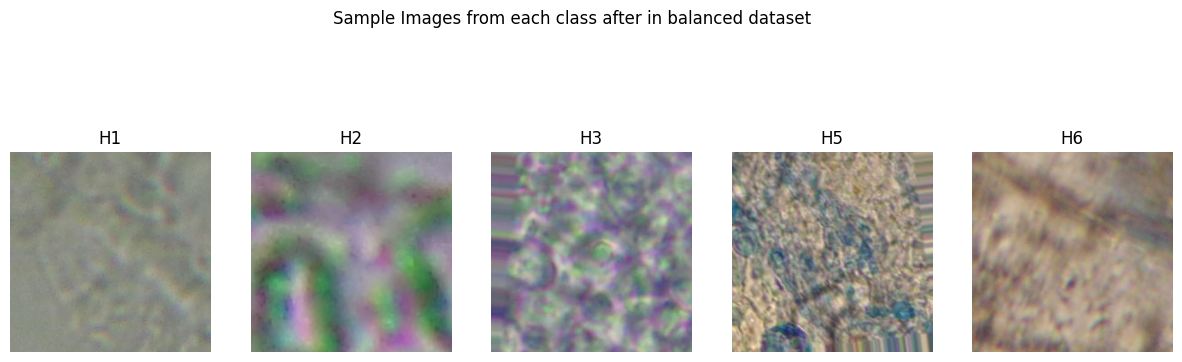

In [ ]:
data = '/content/balanced_defungi'
fig, axs = plt.subplots(1, 5, figsize=(15, 5))
for i, cls in enumerate(class_names):
    sample_path = os.path.join(data, cls, os.listdir(os.path.join(data, cls))[0])
    img = Image.open(sample_path)
    axs[i].imshow(img, cmap='gray')
    axs[i].set_title(cls)
    axs[i].axis('off')
plt.suptitle("Sample Images from each class after in balanced dataset")
plt.show()

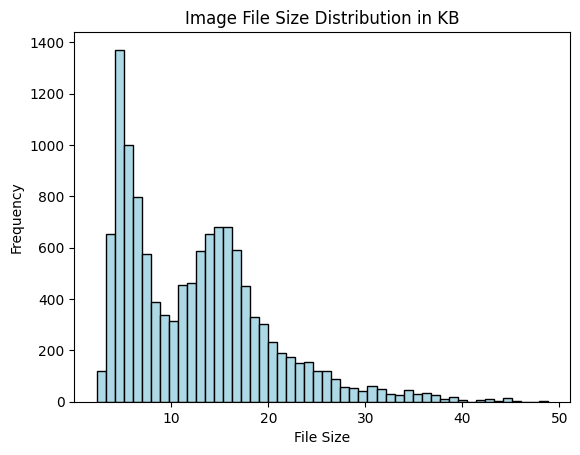

In [ ]:
file_sizes = []
for cls in class_names:
    for img_file in os.listdir(os.path.join(balanced_data_dir, cls)):
        file_path = os.path.join(balanced_data_dir, cls, img_file)
        file_sizes.append(os.path.getsize(file_path) / 1024)

plt.hist(file_sizes, bins=50, color='lightblue', edgecolor='black')
plt.title("Image File Size Distribution in KB")
plt.xlabel("File Size")
plt.ylabel("Frequency")
plt.show()


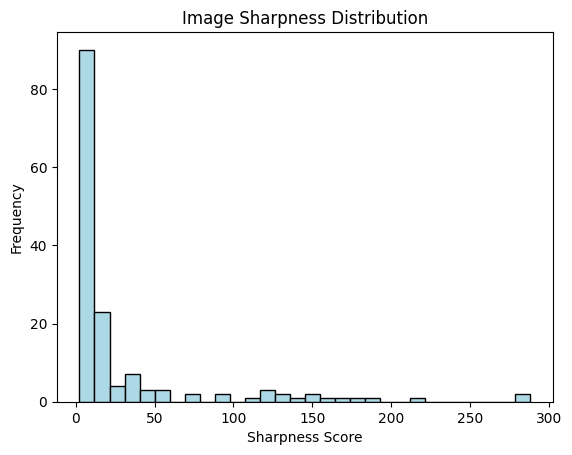

In [ ]:
import cv2

def variance_of_laplacian(image):
    return cv2.Laplacian(image, cv2.CV_64F).var()

sharpness_scores = []
for cls in class_names:
    for img_file in os.listdir(os.path.join(balanced_data_dir, cls))[:30]:
        img = cv2.imread(os.path.join(balanced_data_dir, cls, img_file), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            score = variance_of_laplacian(img)
            sharpness_scores.append(score)

plt.hist(sharpness_scores, bins=30, color='lightblue', edgecolor='black')
plt.title("Image Sharpness Distribution")
plt.xlabel("Sharpness Score")
plt.ylabel("Frequency")
plt.show()

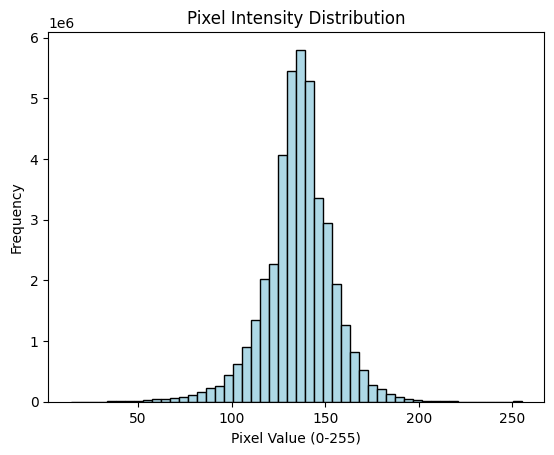

In [ ]:
import cv2

gray_levels = []
for cls in class_names:
    folder = os.path.join(balanced_data_dir, cls)
    for img_file in os.listdir(folder)[:50]:
        img_path = os.path.join(folder, img_file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            gray_levels.extend(img.flatten())

plt.hist(gray_levels, bins=50, color='lightblue', edgecolor='black')
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel Value (0-255)")
plt.ylabel("Frequency")
plt.show()

In [ ]:
from PIL import Image
import pandas as pd
import numpy as np

meta_data = []

for cls in class_names:
    cls_path = os.path.join(balanced_data_dir, cls)
    img_files = os.listdir(cls_path)
    widths, heights, modes = [], [], []

    for img_file in img_files[:50]:
        try:
            img = Image.open(os.path.join(cls_path, img_file))
            widths.append(img.width)
            heights.append(img.height)
            modes.append(img.mode)
        except:
            continue

    avg_width = np.mean(widths)
    avg_height = np.mean(heights)
    mode = max(set(modes), key=modes.count)

    meta_data.append({
        'Class': cls,
        'Image Count': len(img_files),
        'Avg Width': round(avg_width, 2),
        'Avg Height': round(avg_height, 2),
        'Most Common Mode': mode
    })

df_meta = pd.DataFrame(meta_data)
print(df_meta)


  Class  Image Count  Avg Width  Avg Height Most Common Mode
0    H1         2500     500.00      500.00              RGB
1    H2         2500     488.96      488.96              RGB
2    H3         2500     301.28      301.28              RGB
3    H5         2500     301.28      301.28              RGB
4    H6         2500     312.32      312.32              RGB


In [ ]:
import os
from PIL import Image
from google.colab import drive

drive.mount('/content/drive')

balanced_data_dir = '/content/balanced_defungi'
drive_output_dir = '/content/drive/MyDrive/balanced_defungi_224'
os.makedirs(drive_output_dir, exist_ok=True)

class_names = ['H1', 'H2', 'H3', 'H5', 'H6']
resize_size = (224, 224)

for cls in class_names:
    input_cls_path = os.path.join(balanced_data_dir, cls)
    output_cls_path = os.path.join(drive_output_dir, cls)
    os.makedirs(output_cls_path, exist_ok=True)

    for img_file in os.listdir(input_cls_path):
        input_path = os.path.join(input_cls_path, img_file)
        output_path = os.path.join(output_cls_path, img_file)

        try:
            img = Image.open(input_path).convert('RGB')
            img = img.resize(resize_size)
            img.save(output_path)
        except Exception as e:
            print(f"Skipping {img_file}: {e}")

print(drive_output_dir)

Mounted at /content/drive
/content/drive/MyDrive/balanced_defungi_224


In [ ]:
from google.colab import files
import zipfile
import os

uploaded = files.upload()

Saving grayscale_defungi_224.zip to grayscale_defungi_224.zip


In [ ]:
from PIL import Image
from google.colab import drive

drive.mount('/content/drive')
filename = list(uploaded.keys())[0]
with zipfile.ZipFile(filename,'r') as ref:
    ref.extractall('/content/balanced_defungi_224')

data_dir = '/content/balanced_defungi_224'
output_dir = '/content/grayscale_defungi_224'
os.makedirs(output_dir, exist_ok=True)

class_names = ['H1', 'H2', 'H3', 'H5', 'H6']

for cls in class_names:
    input_cls_path = os.path.join(data_dir, cls)
    output_cls_path = os.path.join(output_dir, cls)
    os.makedirs(output_cls_path, exist_ok=True)

    for img_file in os.listdir(input_cls_path):
        input_path = os.path.join(input_cls_path, img_file)
        output_path = os.path.join(output_cls_path, img_file)

        try:
            img = Image.open(input_path).convert('L')
            img.save(output_path)
        except Exception as e:
            print(f"Skipping {img_file}: {e}")

!cp -r /content/grayscale_defungi_224 /content/drive/MyDrive/grayscale_defungi_224

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
filename = list(uploaded.keys())[0]
with zipfile.ZipFile(filename,'r') as ref:
    ref.extractall('/content/grayscale_defungi_224')

grayscale_dir = '/content/grayscale_defungi_224'
class_names = ['H1', 'H2', 'H3', 'H5', 'H6']

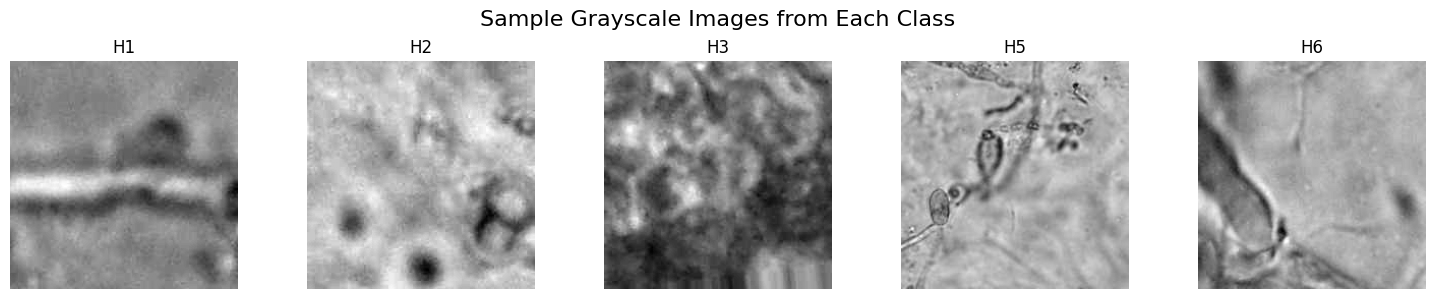

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

plt.figure(figsize=(15, 3))
for idx, cls in enumerate(class_names):
    cls_path = os.path.join(grayscale_dir, cls)
    sample_img_name = os.listdir(cls_path)[0]
    sample_img_path = os.path.join(cls_path, sample_img_name)
    img = Image.open(sample_img_path)
    plt.subplot(1, 5, idx + 1)
    plt.imshow(img, cmap='gray')
    plt.title(cls)
    plt.axis('off')

plt.suptitle("Sample Grayscale Images from Each Class", fontsize=16)
plt.tight_layout()
plt.show()